# **RL Project**
**Done by- Aditya Goel and Sanskar Chandra**

## **Q- Learning Algorithm**

#### Importing Required Libraries

In [ ]:
#import libraries
import numpy as np

## Defining the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning agent, while the possible actions are the agent's outputs.
#### States
The states in the environment are all of the possible locations within the grid. Some of these locations are blocked(**black squares**), while other locations can be travelled by the robot(**white squares**). The **green square** indicates the goal.

The black and green squares are **terminal states**!

The agent's goal is to learn the shortest path where the robot is allowed to travel.

There are 16 possible states (locations). These states are arranged in a grid containing 4 rows and 4 columns. Each location can hence be identified by its row and column index.

In [ ]:
#define the shape of the environment (i.e., its states)
environment_rows = 4
environment_columns = 4

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 4 rows and 4 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in each state. 
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4))

# print(q_values)

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

The AI agent must learn to avoid driving into the blocking area.

In [ ]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
The last component of the environment that we need to define are the **rewards**. 

To help the agent learn, each state (location) in the grid is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

To maximize its cumulative rewards (by minimizing its cumulative punishments), the agent will need find the shortest paths where the agent is allowed to travel (white squares). The agent will also need to learn to avoid crashing into blocked states. (black squares)!

In [ ]:
#Create a 2D numpy array to hold the rewards for each state. 
#The array contains 4 rows and 4 columns (to match the shape of the environment), and each value is initialized to -1.
rewards = np.full((environment_rows, environment_columns), -1.)
rewards[0, 2] = 100. #setting the reward for the the goal to 100

for i in range(0,2):
  row = np.random.randint(environment_rows)
  col = np.random.randint(environment_columns)
  rewards[row, col] = -100.
  
#print rewards matrix
for row in rewards:
  print(row)

[ -1.  -1. 100.  -1.]
[  -1. -100.   -1.   -1.]
[-1. -1. -1. -1.]
[  -1. -100.   -1.   -1.]


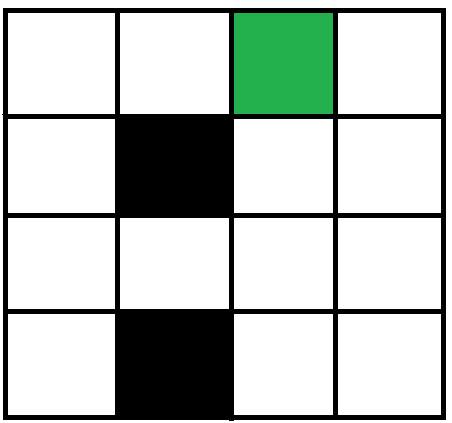

## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths, while simultaneously avoiding crashing into any of the blocked state.

#### Define Helper Functions

In [ ]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon, 
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path where robot is allowed to travel.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#### Train the AI Agent using Q-Learning

In [ ]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)
    
    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

print(q_values)

Training complete!
[[[ 79.1         89.          70.19        79.1       ]
  [ 89.         100.         -19.89999999  79.1       ]
  [  0.           0.           0.           0.        ]
  [ 89.          89.          79.1        100.        ]]

 [[ 79.1        -19.8901      62.17099994  70.18999999]
  [ 89.         -99.         -99.9         70.11981   ]
  [ 99.99        79.1         55.9539     -19.8801    ]
  [ 89.          79.1         70.19        87.03799998]]

 [[ 70.19        54.95235046  54.95389999  62.171     ]
  [-19.899801    62.171      -50.53643585  62.108829  ]
  [ 70.1899983   70.19        54.9539      54.95387957]
  [ 79.1         70.19        62.171       62.171     ]]

 [[ 62.171      -49.55149508  54.38657958  54.95384327]
  [-99.          54.94816547  43.36623     54.9539    ]
  [ 62.171       62.16460371  54.95307347 -50.44299178]
  [ 70.19        62.17092326  62.1709936   54.95384266]]]


## Get Shortest Paths
Now that the agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the grid.

In [ ]:
print(get_shortest_path(0, 2)) #starting at row 0, column 2
print(get_shortest_path(1, 2)) #starting at row 1, column 2
print(get_shortest_path(3, 2)) #starting at row 3, column 2

[]
[[1, 2], [0, 2]]
[[3, 2], [2, 2], [2, 3], [1, 3], [0, 3], [0, 2]]
